In [1]:
# -*- coding: utf-8 -*-
import sys, os
import numpy as np
import pandas as pd
import cobra

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version:  3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version: 0.20.0


In [2]:
def AddRxn(model: cobra.Model,
           newRxnFile):
    """Function of adding new reactions to the model."""
    n1 = len(model.reactions)
    AllAddRxn = pd.read_csv(newRxnFile, sep=',', index_col='RxnID', skipinitialspace=True)
    n2 = len(AllAddRxn)
    for i in range(n2):
        ID = AllAddRxn.index.values[i]
        addRxn = cobra.Reaction(ID)
        model.add_reactions([addRxn])
        addRxnInf = model.reactions[n1 + i]
        addRxnInf.name = AllAddRxn.loc[ID, 'RxnName']
        addRxnInf.reaction = AllAddRxn.loc[ID, 'RxnFormula']
        addRxnInf.subsystem = AllAddRxn.loc[ID, 'Subsystem']
        addRxnInf.lower_bound = AllAddRxn.loc[ID, 'LowerBound']
        addRxnInf.upper_bound = AllAddRxn.loc[ID, 'UpperBound']
    return model

In [3]:
def KORxn(model: cobra.Model,
          rxns2KO: list):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()

In [4]:
def pfba(model: cobra.Model):
    cobra.flux_analysis.pfba(model)
    print(model.summary())

In [5]:
def change_objective(model, product):
    """change objective function"""
    if product in ['accoa_c', 'succoa_c']:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1, 'coa_c': 1})
    elif product in ['g6p_c', 'f6p_c', 'e4p_c', 'r5p_c', 'g3p_c', '3pg_c', 'pep_c']:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1, 'pi_c': 1})
    elif f"EX_{product}" not in model.reactions:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1})
    model.objective = f"EX_{product}"

In [6]:
def flux2file(model: cobra.Model, 
              psw, product, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                      columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                      'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(psw, product))
    df.to_excel(filepath, index=False)

In [7]:
def prodFBA(model, psw, product,saveif):
    solution = model.optimize()
    # print("%s: " %product, round(solution.objective_value, 3))
    # export results
    if saveif: 
        flux2file(model, psw, product)
    return round(solution.objective_value, 3)

 ## Model background

  * Using _E. coli_ full model *i*ML1515.
  * Corrected the transhydrogenase (THD2pp) to one proton translocation.
  * Corrected homoserine dehydrogenase to be irreversible, towards homoserine.
  * Changed MMM (Methylmalonyl-CoA mutase) to be reversible.
  * FolD is reversible, MTHFC and MTHFD.
  * FTL reaction is existed, FTHFLi (irrversible)
  * The model has part of the Ethylmalonyl-CoA pathway, ACACT1r, HACD1 and ECOAH1,
  propanoyl-CoA degradation, MMM and MMCD already.

In [8]:
model = cobra.io.load_json_model(r'..\..\0_ecoli_models\iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)
model.reactions.MMM.bounds = (-1000, 1000)

 ## Base knock-outs
 * pyruvate synthase (POR5), 3pg producing glycerate kinase (GLYCK)
 * aerobic: PFL, OBTFL, FRD2, FRD3
 * FDH4pp, FDH5pp, GART,
 * ATPM
 * the reactions for unrealistic AcCoA production DRPA & PAI2T
 * FORCT

In [9]:
KORxn_base = ['POR5', 'GLYCK', 'FDH4pp', 'FDH5pp', 'ATPM',
              'PFL', 'OBTFL', 'GART', 'DRPA', 'PAI2T',
              'FRD2','FRD3','F6PA','FORCT']

KORxn(model, KORxn_base)

In [10]:
model.reactions.get_by_id('EX_glc__D_e').bounds = (0,0)

model_rump = AddRxn(model, 'NewRxns4Full_RuMP.csv')

unknown metabolite 'h6p_c' created



In [11]:
psws = {
    'THF': 'NewRxns4Full_thf.csv',
    'CoA': 'NewRxns4Full_coA.csv',
    'Pi': 'NewRxns4Full_pi.csv',
}

 ### Production of biomass and the 12 precursors (DOI: 10.1016/j.cell.2016.02.004)

In [12]:
precursors = ['biomass', 'g6p_c', 'f6p_c', 'e4p_c', 'r5p_c', 'g3p_c', 
              '3pg_c', 'pep_c', 'pyr_c', 'accoa_c', 'akg_c', 
              'succoa_c', 'oaa_c']

 ## NADPH-CoA, NADPH-Pi, NADPH-THF

In [13]:
# saveif = True
saveif = False
nadph_results = pd.DataFrame()

for psw, pswrxns in psws.items():
    with model_rump as m:
        m.reactions.EX_for_e.lower_bound = -10
        _m = AddRxn(m, pswrxns)
        if psw != 'THF':
            AddKO = ['FTHFLi',] 
            KORxn(_m, AddKO)
        for precursor in precursors:
            with _m:
                if precursor != 'biomass':
                    change_objective(_m, precursor)
                sol = prodFBA(_m, psw, precursor, saveif)
                nadph_results.loc[precursor, psw] = sol

nadph_results
nadph_results.to_excel('formate reduction_FBA_nadph.xlsx')

unknown metabolite 'forp_c' created



 change to be NADH dependent

In [14]:
# saveif = True
saveif = False
nadh_results = pd.DataFrame()

for psw, pswrxns in psws.items():
    with model_rump as m:
        m.reactions.EX_for_e.lower_bound = -10
        _m = AddRxn(m, pswrxns)

        if psw == 'THF': 
            _m.reactions.get_by_id('MTHFD').add_metabolites({
                "nad_c":-1,"nadp_c":1,"nadh_c":1,"nadph_c":-1
            })
        elif psw == 'Pi': 
            _m.reactions.get_by_id('FPR').add_metabolites({
                "nadh_c":-1,"nadp_c":-1,"nad_c":1,"nadph_c":1
            })
            AddKO = ['FTHFLi',] 
            KORxn(_m, AddKO)
        elif psw == 'CoA': 
            _m.reactions.get_by_id('FCR').add_metabolites({
                "nadh_c":-1,"nadp_c":-1,"nad_c":1,"nadph_c":1
            })
            AddKO = ['FTHFLi',] 
            KORxn(_m, AddKO)

        for precursor in precursors:
            with _m:
                if precursor != 'biomass':
                    change_objective(_m, precursor)
                sol = prodFBA(_m, psw, precursor, saveif)
                nadh_results.loc[precursor, psw] = sol

nadh_results
nadh_results.to_excel('formate reduction_FBA_nadh.xlsx')

unknown metabolite 'forp_c' created


<ipython-input-15-d7a81e7b9dd9>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(str, np.arange(0, 7, 1)/10))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


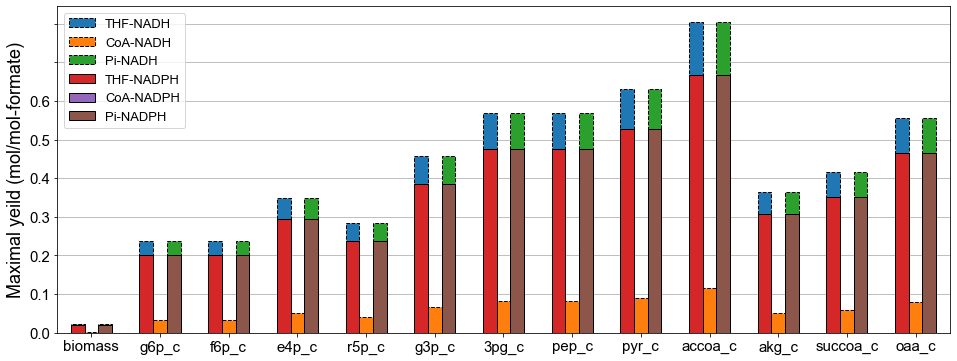

In [15]:
import matplotlib.pyplot as plt 

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['savefig.bbox'] = 'tight'

x = np.arange(len(precursors))
witdh = 0.2

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xticks(x)
ax.set_xlim(-0.5, 12.5)
ax.set_xticklabels(precursors)
ax.set_yticklabels(map(str, np.arange(0, 7, 1)/10))
ax.set_ylabel('Maximal yeild (mol/mol-formate)')
plt.grid(which='both', axis='y')

ax.bar(x-witdh, nadh_results['THF'], witdh, label='THF-NADH',edgecolor='k',lw=1,ls='--')
ax.bar(x, nadh_results['CoA'], witdh, label = 'CoA-NADH',edgecolor='k',lw=1,ls='--')
ax.bar(x+witdh, nadh_results['Pi'], witdh, label = 'Pi-NADH',edgecolor='k',lw=1,ls='--')

ax.bar(x-witdh, nadph_results['THF'], witdh, label='THF-NADPH',edgecolor='k',lw=1,ls='-')
ax.bar(x, nadph_results['CoA'], witdh, label = 'CoA-NADPH',edgecolor='k',lw=1,ls='-')
ax.bar(x+witdh, nadph_results['Pi'], witdh, label = 'Pi-NADPH',edgecolor='k',lw=1,ls='-')

plt.legend()
plt.savefig('12 precursors production figure_stacked.eps', dpi=300)
plt.show()